In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold

# import the model
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error

In [2]:
# read data
train = pd.read_csv('Housing_dataset_train.csv')
test = pd.read_csv('Housing_dataset_test.csv')
sample = pd.read_csv('Sample_submission.csv')

In [3]:
train.head()

,ID,loc,title,bedroom,bathroom,parking_space,price
0,3583,Katsina,Semi-detached duplex,2.0,2.0,1.0,1149999.565
1,2748,Ondo,Apartment,NaN,2.0,4.0,1672416.689
2,9261,Ekiti,NaN,7.0,5.0,NaN,3364799.814
3,2224,Anambra,Detached duplex,5.0,2.0,4.0,2410306.756
4,10300,Kogi,Terrace duplex,NaN,5.0,6.0,2600700.898


In [4]:
test.head()

,ID,loc,title,bedroom,bathroom,parking_space
0,845,Kano,Penthouse,4,1,2
1,1924,Adamawa,Apartment,2,2,4
2,10718,Adamawa,Bungalow,2,7,2
3,12076,Lagos,Mansion,9,5,2
4,12254,Gombe,Semi-detached duplex,5,6,1


In [5]:
sample.head()

,ID
0,845
1,1924
2,10718
3,12076
4,12254


In [6]:
# Check size and shape of datasets
train.shape, test.shape, sample.shape

((14000, 7), (6000, 6), (6000, 1))

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             14000 non-null  int64  
 1   loc            12187 non-null  object 
 2   title          12278 non-null  object 
 3   bedroom        12201 non-null  float64
 4   bathroom       12195 non-null  float64
 5   parking_space  12189 non-null  float64
 6   price          14000 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 765.8+ KB


In [8]:
train.describe()

,ID,bedroom,bathroom,parking_space,price
count,14000.000000,12201.000000,12195.000000,12189.000000,1.400000e+04
mean,4862.700357,4.308171,3.134235,3.169825,2.138082e+06
std,3818.348214,2.441165,2.035950,1.599415,1.083057e+06
min,0.000000,1.000000,1.000000,1.000000,4.319673e+05
25%,1672.750000,2.000000,1.000000,2.000000,1.393990e+06
50%,3527.000000,4.000000,2.000000,3.000000,1.895223e+06
75%,8011.250000,6.000000,5.000000,4.000000,2.586699e+06
max,12999.000000,9.000000,7.000000,6.000000,1.656849e+07


In [9]:
train.isnull().sum()

ID                  0
loc              1813
title            1722
bedroom          1799
bathroom         1805
parking_space    1811
price               0
dtype: int64

In [10]:
# Drop rows with missing values in 'loc' and 'title' columns
train = train.dropna(subset=['loc', 'title'])


In [11]:
'''
# Filling missing values for categorical columns with mode
categorical_columns = ['loc', 'title']
for col in categorical_columns:
    train[col].fillna(train[col].mode()[0], inplace=True)
'''

# Filling missing values for positively skewed numeric columns with median
skewed_numeric_columns = ['bedroom', 'bathroom', 'parking_space']
for col in skewed_numeric_columns:
    if train[col].skew() > 0:  # Check if the column is positively skewed
        train[col].fillna(train[col].median(), inplace=True)
    else:
        train[col].fillna(train[col].mean(), inplace=True)  # For other columns, use the mean


In [12]:
train.shape

(10531, 7)

In [13]:
# Check for duplicates
train.duplicated().any(), test.duplicated().any()

(False, False)

In [14]:
(train[['bedroom','bathroom', 'parking_space']] == 0).sum()

bedroom          0
bathroom         0
parking_space    0
dtype: int64

C:\Users\RIDWAN\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


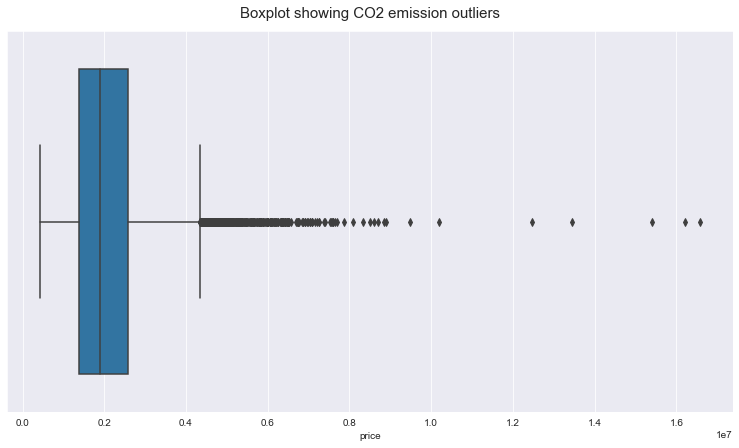

In [15]:

# Plotting boxplot for the price to check for outliers
sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.boxplot(train.price)
plt.title('Boxplot showing CO2 emission outliers', y = 1.02, fontsize = 15)  
plt.show()


In [16]:

# Calculate the 5th and 95th percentiles of the 'price' column
price_lower_bound = train['price'].quantile(0.05)
price_upper_bound = train['price'].quantile(0.95)

# Apply Winsorization to cap extreme values at the 5th and 95th percentiles
train['price'] = np.clip(train['price'], price_lower_bound, price_upper_bound)



C:\Users\RIDWAN\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


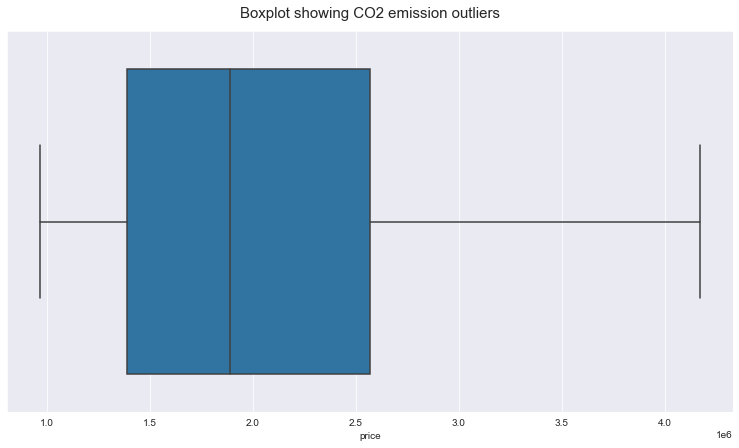

In [17]:
# Plotting boxplot for the price to check for outliers
sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.boxplot(train.price)
plt.title('Boxplot showing CO2 emission outliers', y = 1.02, fontsize = 15)  
plt.show()

In [18]:
train.columns

Index(['ID', 'loc', 'title', 'bedroom', 'bathroom', 'parking_space', 'price'], dtype='object')

In [19]:
train['loc'].unique()

array(['Katsina', 'Ondo', 'Anambra', 'Kogi', 'Borno', 'Kwara', 'Osun',
       'Kaduna', 'Ogun', 'Bayelsa', 'Abia', 'Rivers', 'Taraba', 'Ebonyi',
       'Kebbi', 'Enugu', 'Edo', 'Nasarawa', 'Kano', 'Delta', 'Yobe',
       'Benue', 'Bauchi', 'Cross River', 'Niger', 'Adamawa', 'Plateau',
       'Imo', 'Oyo', 'Zamfara', 'Sokoto', 'Jigawa', 'Gombe', 'Lagos',
       'Akwa Ibom', 'Ekiti'], dtype=object)

In [20]:
train.title.unique()

array(['Semi-detached duplex', 'Apartment', 'Detached duplex',
       'Terrace duplex', 'Mansion', 'Bungalow', 'Penthouse', 'Townhouse',
       'Flat', 'Cottage'], dtype=object)

In [21]:
def create_features(df):
    # Create 'total_rooms' feature by adding 'bedroom' and 'bathroom' columns
    df['total_rooms'] = df['bedroom'] + df['bathroom']

    # Create 'bedroom_bathroom_ratio' feature based on the condition
    df['bedroom_bathroom_ratio'] = np.where(df['bathroom'] > df['bedroom'], 1,
                                            np.where(df['bathroom'] < df['bedroom'], 2, 3))
    # 1 = less rooms, 2 = more rooms, 3 = equal rooms

    # Create 'bathroom_type' feature based on the condition
    df['bathroom_type'] = np.where(df['bathroom'] == 1, 1,
                                   np.where(df['bathroom'] == df['bedroom'], 2, 3))
    # 1 = single, 2 = master, 3 = shared

    # Define the bins and labels for the bedroom groups
    bins = [0, 2, 4, np.inf]
    labels = ['1', '2', '3']  # 1 = 0-2 bedrooms, 2 = 3-4 bedrooms, 3 = 5+ bedrooms

    # Create 'bedroom_group' feature, calculate 'total_amenities', and drop the original 'bedroom' column
    df['bedroom_group'] = pd.cut(df['bedroom'], bins=bins, labels=labels, right=False).astype(float)

    return df

In [22]:
train = create_features(train)
test = create_features(test)

In [23]:
# Define the mapping of states to regions
state_to_region = {
    'Katsina': 'North-west',
    'Ondo': 'South-west',
    'Ekiti': 'South-west',
    'Anambra': 'South-east',
    'Kogi': 'North-central',
    'Borno': 'North-east',
    'Kwara': 'North-central',
    'Osun': 'South-west',
    'Kaduna': 'North-west',
    'Ogun': 'South-west',
    'Bayelsa': 'South-south',
    'Abia': 'South-east',
    'Rivers': 'South-south',
    'Taraba': 'North-east',
    'Ebonyi': 'South-east',
    'Kebbi': 'North-west',
    'Enugu': 'South-east',
    'Edo': 'South-south',
    'Nasarawa': 'North-central',
    'Delta': 'South-south',
    'Kano': 'North-west',
    'Yobe': 'North-east',
    'Benue': 'North-central',
    'Bauchi': 'North-east',
    'Cross River': 'South-south',
    'Niger': 'North-central',
    'Adamawa': 'North-east',
    'Plateau': 'North-central',
    'Imo': 'South-east',
    'Oyo': 'South-west',
    'Zamfara': 'North-west',
    'Sokoto': 'North-west',
    'Jigawa': 'North-west',
    'Gombe': 'North-east',
    'Akwa Ibom': 'South-south',
    'Lagos': 'South-west'
}

# Create a new column 'region' by mapping 'loc' column to regions using the state_to_region mapping
train['region'] = train['loc'].map(state_to_region)
test['region'] = test['loc'].map(state_to_region)

In [24]:
train.region.nunique()

6

In [25]:

# Calculate the mean price for each house type
house_type_mean_price = train.groupby('title')['price'].mean().sort_values(ascending=False)

# Create a dictionary to map each house type to its rank based on mean price
house_type_rank = {house_type: rank for rank, house_type in enumerate(house_type_mean_price.index, 1)}
house_type_rank

{'Mansion': 1,
 'Penthouse': 2,
 'Detached duplex': 3,
 'Townhouse': 4,
 'Terrace duplex': 5,
 'Semi-detached duplex': 6,
 'Bungalow': 7,
 'Flat': 8,
 'Apartment': 9,
 'Cottage': 10}

In [26]:
# Convert the 'title' column to a categorical data type using the mapping
train['title'] = train['title'].map(house_type_rank)
test['title'] = test['title'].map(house_type_rank)

In [27]:
# Perform one-hot encoding using get_dummies
train = pd.get_dummies(train, columns=['loc'], drop_first=True)
test = pd.get_dummies(test, columns=['loc'], drop_first=True)

train = pd.get_dummies(train, columns=['region'], drop_first=True)
test = pd.get_dummies(test, columns=['region'], drop_first=True)

In [28]:
X = train.drop(['ID','price'], axis=1)
y = train['price']

test.drop(columns=["ID"], inplace=True)

In [29]:
X_train,X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, random_state=42)

In [30]:


# Initialize the regression models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'AdaBoost': AdaBoostRegressor(),
    'Support Vector Regression': SVR(),
    'K-Nearest Neighbors': KNeighborsRegressor(),
    'Decision Tree': DecisionTreeRegressor(),
    'CatBoost': CatBoostRegressor(),
    'XGBoost': XGBRegressor(),
    'LightGBM': LGBMRegressor(),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'ElasticNet': ElasticNet(),
}


# Train and evaluate each model
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results.append((name, rmse))

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['Model', 'RMSE'])

# Sort by RMSE in ascending order
results_df = results_df.sort_values(by='RMSE', ascending=True)

# Print the best model and its RMSE
print("Best Model:")
print(results_df.head(1))

Learning rate set to 0.046056
0:	learn: 852622.0881918	total: 136ms	remaining: 2m 15s
1:	learn: 828304.2276610	total: 140ms	remaining: 1m 9s
2:	learn: 805841.4043745	total: 143ms	remaining: 47.6s
3:	learn: 784062.9763445	total: 146ms	remaining: 36.4s
4:	learn: 761738.5950130	total: 149ms	remaining: 29.7s
5:	learn: 740558.8430372	total: 152ms	remaining: 25.2s
6:	learn: 722529.6782129	total: 155ms	remaining: 22s
7:	learn: 702050.2602850	total: 158ms	remaining: 19.6s
8:	learn: 685037.6724607	total: 161ms	remaining: 17.7s
9:	learn: 667927.9288032	total: 164ms	remaining: 16.2s
10:	learn: 652227.1773398	total: 167ms	remaining: 15s
11:	learn: 638720.0799420	total: 172ms	remaining: 14.1s
12:	learn: 625408.6785356	total: 174ms	remaining: 13.2s
13:	learn: 610708.7747640	total: 176ms	remaining: 12.4s
14:	learn: 597363.8581346	total: 179ms	remaining: 11.7s
15:	learn: 583428.6285767	total: 181ms	remaining: 11.1s
16:	learn: 572102.7857516	total: 183ms	remaining: 10.6s
17:	learn: 560914.7860554	total

215:	learn: 279012.5262481	total: 501ms	remaining: 1.82s
216:	learn: 278754.0643026	total: 503ms	remaining: 1.81s
217:	learn: 278524.9937168	total: 505ms	remaining: 1.81s
218:	learn: 278292.6582269	total: 507ms	remaining: 1.81s
219:	learn: 277997.5254489	total: 508ms	remaining: 1.8s
220:	learn: 277659.4339308	total: 510ms	remaining: 1.8s
221:	learn: 277371.5787003	total: 511ms	remaining: 1.79s
222:	learn: 277125.4176745	total: 513ms	remaining: 1.79s
223:	learn: 276807.7306240	total: 515ms	remaining: 1.78s
224:	learn: 276383.4705457	total: 517ms	remaining: 1.78s
225:	learn: 276062.4932864	total: 519ms	remaining: 1.78s
226:	learn: 275805.1923298	total: 521ms	remaining: 1.77s
227:	learn: 275587.1219223	total: 523ms	remaining: 1.77s
228:	learn: 275280.2019014	total: 525ms	remaining: 1.77s
229:	learn: 274894.1598920	total: 527ms	remaining: 1.76s
230:	learn: 274663.7433208	total: 529ms	remaining: 1.76s
231:	learn: 274452.2759732	total: 531ms	remaining: 1.76s
232:	learn: 274197.4208154	total:

410:	learn: 238008.0444996	total: 843ms	remaining: 1.21s
411:	learn: 237839.9645802	total: 845ms	remaining: 1.21s
412:	learn: 237723.1323972	total: 846ms	remaining: 1.2s
413:	learn: 237524.9594835	total: 848ms	remaining: 1.2s
414:	learn: 237382.1238126	total: 849ms	remaining: 1.2s
415:	learn: 237254.0763539	total: 851ms	remaining: 1.19s
416:	learn: 237122.7847853	total: 852ms	remaining: 1.19s
417:	learn: 236993.6882482	total: 854ms	remaining: 1.19s
418:	learn: 236873.1046455	total: 855ms	remaining: 1.19s
419:	learn: 236757.8558897	total: 857ms	remaining: 1.18s
420:	learn: 236561.0395440	total: 858ms	remaining: 1.18s
421:	learn: 236395.8442358	total: 860ms	remaining: 1.18s
422:	learn: 236249.3614524	total: 862ms	remaining: 1.18s
423:	learn: 236051.6962340	total: 873ms	remaining: 1.19s
424:	learn: 235895.5215663	total: 874ms	remaining: 1.18s
425:	learn: 235768.0156789	total: 875ms	remaining: 1.18s
426:	learn: 235621.6277766	total: 877ms	remaining: 1.18s
427:	learn: 235389.7288245	total: 

619:	learn: 210750.2002171	total: 1.18s	remaining: 724ms
620:	learn: 210666.0310784	total: 1.18s	remaining: 722ms
621:	learn: 210615.0598218	total: 1.19s	remaining: 720ms
622:	learn: 210536.7947634	total: 1.19s	remaining: 718ms
623:	learn: 210353.9709519	total: 1.19s	remaining: 716ms
624:	learn: 210263.4354258	total: 1.19s	remaining: 714ms
625:	learn: 210152.7214076	total: 1.19s	remaining: 712ms
626:	learn: 210064.2987089	total: 1.19s	remaining: 711ms
627:	learn: 209976.6374237	total: 1.2s	remaining: 709ms
628:	learn: 209843.5947996	total: 1.2s	remaining: 707ms
629:	learn: 209706.8546912	total: 1.2s	remaining: 705ms
630:	learn: 209623.0106351	total: 1.2s	remaining: 703ms
631:	learn: 209518.8561476	total: 1.2s	remaining: 701ms
632:	learn: 209403.2363159	total: 1.21s	remaining: 699ms
633:	learn: 209320.8463968	total: 1.21s	remaining: 697ms
634:	learn: 209189.9198803	total: 1.21s	remaining: 695ms
635:	learn: 209119.6709558	total: 1.21s	remaining: 693ms
636:	learn: 208978.1575117	total: 1.

782:	learn: 195140.8537552	total: 1.46s	remaining: 404ms
783:	learn: 194980.6910405	total: 1.46s	remaining: 402ms
784:	learn: 194882.6025095	total: 1.46s	remaining: 400ms
785:	learn: 194823.6929719	total: 1.46s	remaining: 398ms
786:	learn: 194776.8214235	total: 1.46s	remaining: 396ms
787:	learn: 194699.6225272	total: 1.47s	remaining: 394ms
788:	learn: 194615.7410501	total: 1.47s	remaining: 392ms
789:	learn: 194545.7413395	total: 1.47s	remaining: 390ms
790:	learn: 194427.5099048	total: 1.47s	remaining: 389ms
791:	learn: 194318.4390488	total: 1.47s	remaining: 387ms
792:	learn: 194237.3540694	total: 1.47s	remaining: 385ms
793:	learn: 194157.7784803	total: 1.47s	remaining: 383ms
794:	learn: 194095.6890183	total: 1.48s	remaining: 381ms
795:	learn: 194000.5013617	total: 1.48s	remaining: 379ms
796:	learn: 193881.3452798	total: 1.48s	remaining: 377ms
797:	learn: 193793.9923205	total: 1.48s	remaining: 375ms
798:	learn: 193715.6554584	total: 1.48s	remaining: 373ms
799:	learn: 193615.5825917	tota

990:	learn: 179009.4663806	total: 1.79s	remaining: 16.3ms
991:	learn: 178946.5448870	total: 1.79s	remaining: 14.5ms
992:	learn: 178902.7039099	total: 1.79s	remaining: 12.7ms
993:	learn: 178829.0274376	total: 1.8s	remaining: 10.8ms
994:	learn: 178780.9831306	total: 1.8s	remaining: 9.04ms
995:	learn: 178672.9351659	total: 1.8s	remaining: 7.23ms
996:	learn: 178574.2082247	total: 1.8s	remaining: 5.43ms
997:	learn: 178518.7572454	total: 1.8s	remaining: 3.62ms
998:	learn: 178444.1379502	total: 1.81s	remaining: 1.81ms
999:	learn: 178329.6151302	total: 1.81s	remaining: 0us
Best Model:
      Model           RMSE
9  LightGBM  345333.369086


C:\Users\RIDWAN\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.452e+13, tolerance: 1.628e+11
  model = cd_fast.enet_coordinate_descent(


In [31]:
results_df

,Model,RMSE
9,LightGBM,345333.369086
7,CatBoost,347082.493454
2,Gradient Boosting,349908.775995
1,Random Forest,374707.930806
8,XGBoost,381919.085362
11,Ridge,412957.079460
0,Linear Regression,413406.580347
10,Lasso,413425.612111
5,K-Nearest Neighbors,489359.364132
6,Decision Tree,491165.804387


In [32]:

# Define hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100, 150], # Number of boosting stages to be run
    'learning_rate': [0.05, 0.1, 0.2], # Shrinkage parameter to prevent overfitting
    'max_depth': [3, 4, 5], # Maximum depth of the individual trees
}

# Perform KFold cross-validation for hyperparameter tuning
kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_params = None
best_rmse = float('inf')

for n_estimators in param_grid['n_estimators']:
    for learning_rate in param_grid['learning_rate']:
        for max_depth in param_grid['max_depth']:
            rmses = []
            for train_idx, val_idx in kf.split(X):
                X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
                y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

                catboost_model = CatBoostRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=42)
                catboost_model.fit(X_train, y_train, verbose=False)
                y_pred = catboost_model.predict(X_val)
                rmse = mean_squared_error(y_val, y_pred, squared=False)
                rmses.append(rmse)

            mean_rmse = np.mean(rmses)
            if mean_rmse < best_rmse:
                best_rmse = mean_rmse
                best_params = {
                    'n_estimators': n_estimators,
                    'learning_rate': learning_rate,
                    'max_depth': max_depth
                }

# Initialize the best CatBoost Regressor with the best hyperparameters
best_catboost_model = CatBoostRegressor(**best_params, random_state=42)

# Train the model on the full training data
best_catboost_model.fit(X, y, verbose=False)

# Predict on the test set
y_pred = best_catboost_model.predict(X_test)

# Calculate and print RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Root Mean Squared Error for CatBoost Regressor = {rmse:.2f}")


Root Mean Squared Error for CatBoost Regressor = 302675.40


In [33]:

# Define hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100, 150],  # Number of boosting stages to be run
    'learning_rate': [0.05, 0.1, 0.2],  # Shrinkage parameter to prevent overfitting
    'max_depth': [3, 4, 5],  # Maximum depth of the individual trees
}

# Perform KFold cross-validation for hyperparameter tuning
kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_params = None
best_rmse = float('inf')

for n_estimators in param_grid['n_estimators']:
    for learning_rate in param_grid['learning_rate']:
        for max_depth in param_grid['max_depth']:
            rmses = []
            for train_idx, val_idx in kf.split(X):
                X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
                y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

                lgbm_model = LGBMRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=42)
                lgbm_model.fit(X_train, y_train)
                y_pred = lgbm_model.predict(X_val)
                rmse = mean_squared_error(y_val, y_pred, squared=False)
                rmses.append(rmse)

            mean_rmse = np.mean(rmses)
            if mean_rmse < best_rmse:
                best_rmse = mean_rmse
                best_params = {
                    'n_estimators': n_estimators,
                    'learning_rate': learning_rate,
                    'max_depth': max_depth
                }

# Initialize the best LGBM Regressor with the best hyperparameters
best_lgbm_model = LGBMRegressor(**best_params, random_state=42)

# Train the model on the full training data
best_lgbm_model.fit(X, y)

# Predict on the test set
y_pred = best_lgbm_model.predict(X_test)

# Calculate and print RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Root Mean Squared Error for LGBM Regressor = {rmse:.2f}")

Root Mean Squared Error for LGBM Regressor = 298115.11


In [34]:
# Define hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100, 150],  # Number of boosting stages to be run
    'learning_rate': [0.05, 0.1, 0.2],  # Shrinkage parameter to prevent overfitting
    'max_depth': [3, 4, 5],  # Maximum depth of the individual trees
}

# Perform KFold cross-validation for hyperparameter tuning
kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_params = None
best_rmse = float('inf')

for n_estimators in param_grid['n_estimators']:
    for learning_rate in param_grid['learning_rate']:
        for max_depth in param_grid['max_depth']:
            rmses = []
            for train_idx, val_idx in kf.split(X):
                X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
                y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

                gb_model = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=42)
                gb_model.fit(X_train, y_train)
                y_pred = gb_model.predict(X_val)
                rmse = mean_squared_error(y_val, y_pred, squared=False)
                rmses.append(rmse)

            mean_rmse = np.mean(rmses)
            if mean_rmse < best_rmse:
                best_rmse = mean_rmse
                best_params = {
                    'n_estimators': n_estimators,
                    'learning_rate': learning_rate,
                    'max_depth': max_depth
                }

# Initialize the best Gradient Boosting Regressor with the best hyperparameters
best_gb_model = GradientBoostingRegressor(**best_params, random_state=42)

# Train the model on the full training data
best_gb_model.fit(X, y)

# Predict on the test set
y_pred = best_gb_model.predict(X_test)

# Calculate and print RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Root Mean Squared Error for Gradient Boosting Regressor = {rmse:.2f}")

Root Mean Squared Error for Gradient Boosting Regressor = 307027.89


In [ ]:
'''

# Get feature importances
importances = best_lgbm_model.feature_importances_

# Sort indices by importance score 
indices = np.argsort(importances)

# Print feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{f + 1}. Feature '{X_train.columns[indices[f]]}' with importance {importances[indices[f]]:.4f}")

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()
'''

In [ ]:
# Once your model is trained and tuned, you can make predictions on X_test_scaled for final evaluation
y_test_pred =  best_catboost_model.predict(test)

# For submission, create a DataFrame using the sample_submission's "id" column and the model's predictions
submission_df = pd.DataFrame({
    "ID": sample.ID,
    "price": y_test_pred
})

# Save the submission DataFrame to a CSV file
submission_df.to_csv("pred4_6.csv", index=False)

In [ ]:
pd.read_csv('pred4_4.csv').head()

In [ ]:
# Once your model is trained and tuned, you can make predictions on X_test_scaled for final evaluation
y_test_pred =  best_lgbm_model.predict(test)

# For submission, create a DataFrame using the sample_submission's "id" column and the model's predictions
submission_df = pd.DataFrame({
    "ID": sample.ID,
    "price": y_test_pred
})

# Save the submission DataFrame to a CSV file
submission_df.to_csv("pred4_7.csv", index=False)

In [ ]:
# Once your model is trained and tuned, you can make predictions on X_test_scaled for final evaluation
y_test_pred =  best_gb_model.predict(test)

# For submission, create a DataFrame using the sample_submission's "id" column and the model's predictions
submission_df = pd.DataFrame({
    "ID": sample.ID,
    "price": y_test_pred
})

# Save the submission DataFrame to a CSV file
submission_df.to_csv("pred4_8 .csv", index=False)